# Introduction and data collection

In the past decade CNN have shown great performances for classification tasks on images. Famous benchmark datasets includes ImageNet but also for tasks near ours : classifying images of traffic signs, such as the Germany Traffic Sign Benchmarks (https://benchmark.ini.rub.de/). We focused our task into classifiying into 3 classes with french traffic sign : blocked road, speed limit and a general "other" class with every other kind of traffic signs. 

We created our image dataset from images recovered on Google Images with web-scraping and we also took pictures in the street with our cell phone.

Scraping generally defines a technique for extracting content (information) from one or more websites completely automatically. We used the selenium library to scrap images with the Firefox driver, the process executes the search on Google and iterate over the images then save them. 

We selected 100 images among the links of Google Images containing the following keywords:
- Panneaux sens interdit
- Rue sens interdit
- Panneaux Vitesse limite
- Panneaux Vitesse 30
- Panneaux Vitesse 20
- Panneaux Routiers

Then we used a custom tool made with the library `opencv` to quickly crop images.

Both tools as well as our dataset can be found on github : https://github.com/sambent15/PanneauxClassifier

# Imports

We first proceed to the import of needed packages. Our simple custom model will be implemented using `pytorch` pretrained models like the one we will be using (ResNet-34) can be in a straight forward way using `torchvision`.
Other packages (`os`, `tqdm`, `numpy` are used for other treatments and manipulation out of the main networks).

In [1]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import time
from tqdm import tqdm
import torchvision

# Global parameters

We set various parameters : 
* The image size is set to 64 pixels (it's a sufficient size not to loose information for traffic signs, and using square image is consistent with our task and the use of squared convolutions)
* The batch size is set to 16
* We use (if possible) the single GPU provided by Kaggle
* We proceed to 40 epochs for each model, either for full training or fine tuning
* The parameters of the trained models are saved every 2 epoch

In [2]:
img_size=64
batch_size=16
workers=2
ngpu=1
num_epochs=40
NUM_CLASSES=3
save_epochs=2

#Define the devide to be used
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Dataloader

We implemented our dataset in the `pytorch` Framework using `dataset.ImageFolder` and we proceed to both resizing and data augmentation with `torch.transforms`. Using `RandomCrop`, `RandomHorizontalFlip` and `RandomPerspective` the images will take different appearances for each iterations, thus at each epoch we use slightly different images. This kind of transformation is useful to have an adaptable model that is not overfitted even though our dataset is limited (see below for the number of images per classes). In the `DataLoader` creation we used shuffling to use different images in each batch at each epoch.

Note that images are normalized to match the distribution of the training set used for the pretraining of the ResNet-34 model we are using below.

In [3]:
#Create the dataset
root_path="../input/panneauxv3/00_train"

train_dataset = dset.ImageFolder(root=root_path,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.RandomCrop(img_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomPerspective(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                           ]))


# Create the dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,drop_last=True)

label_names=["other","s_interdit","vit_lim"]

In [4]:
#Create the validation dataset
root_path="../input/panneauxv3/00_validation"

val_dataset = dset.ImageFolder(root=root_path,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.RandomCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                           ]))


# Create the validation dataloader
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,drop_last=True)

We used the following to see that our dataset has uneven classes. We defined `trainloader_weights` that reflects the distribution of images in each of the classes for the training set. It will be used in the Cross Entropy loss to account for this inequal distribution of classes when computing the loss.

In [5]:
print("vit_lim has %d train images"%(len(os.listdir("../input/panneauxv3/00_train/vit_lim"))))
print("vit_lim has %d test images"%(len(os.listdir("../input/panneauxv3/00_test/vit_lim"))))
print("vit_lim has %d val images"%(len(os.listdir("../input/panneauxv3/00_validation/vit_lim"))))

print("s_interdit has %d train images"%(len(os.listdir("../input/panneauxv3/00_train/s_interdit"))))
print("s_interdit has %d test images"%(len(os.listdir("../input/panneauxv3/00_test/s_interdit"))))
print("s_interdit has %d val images"%(len(os.listdir("../input/panneauxv3/00_validation/s_interdit"))))

print("other has %d train images"%(len(os.listdir("../input/panneauxv3/00_train/other"))))
print("other has %d test images"%(len(os.listdir("../input/panneauxv3/00_test/other"))))
print("other has %d val images"%(len(os.listdir("../input/panneauxv3/00_validation/other"))))

vit_lim has 85 train images
vit_lim has 32 test images
vit_lim has 16 val images
s_interdit has 169 train images
s_interdit has 22 test images
s_interdit has 16 val images
other has 217 train images
other has 40 test images
other has 16 val images


In [6]:
#Weights for the cross entropy loss

total_train=len(os.listdir("../input/panneauxv2/00_train/vit_lim"))+len(os.listdir("../input/panneauxv2/00_train/s_interdit"))+len(os.listdir("../input/panneauxv2/00_train/other"))
trainloader_weights=torch.tensor(([len(os.listdir("../input/panneauxv2/00_train/other"))/total_train,len(os.listdir("../input/panneauxv2/00_train/s_interdit"))/total_train,len(os.listdir("../input/panneauxv2/00_train/vit_lim"))/total_train])).to(device)
print(trainloader_weights)

tensor([0.4103, 0.3846, 0.2051], device='cuda:0')


# Visualization

We visualize the images after transformation with their ground truth label. Most traffic sign are fully represented in the images but non square ones (almost only in the `other` class) can't be fully visualized and are randomly cropped along their larger dimension to match the $64\times 64$ image size used in the networks.

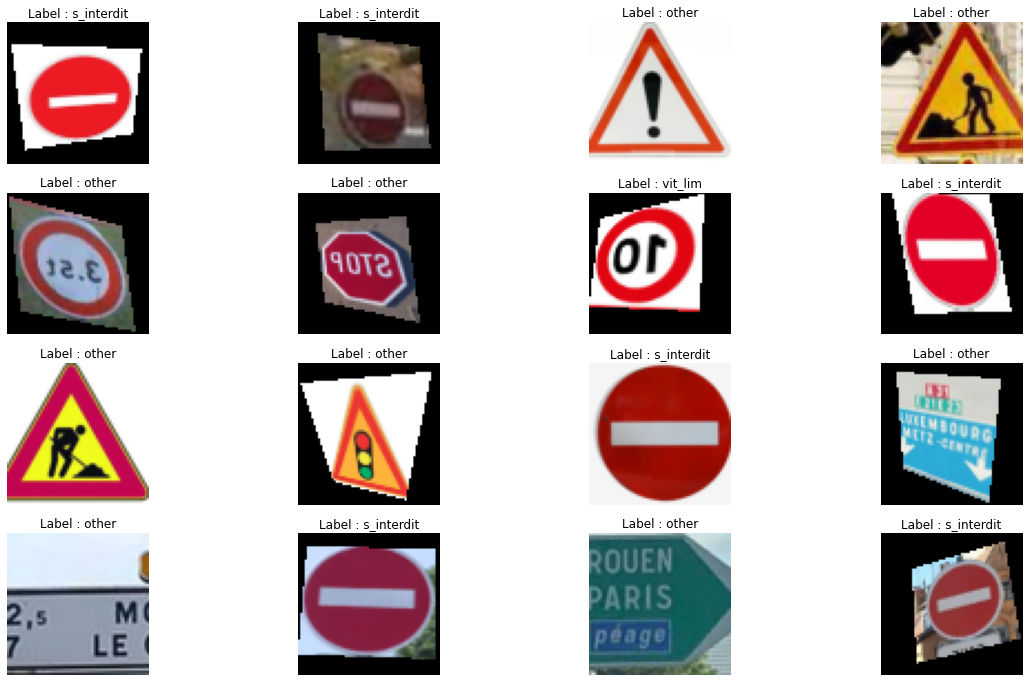

In [7]:
real_batch = next(iter(trainloader))
images=real_batch[0]
labels=real_batch[1]
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])
images = images * STD[:, None, None] + MEAN[:, None, None]
plt.figure(figsize=(20,12))
i=0
for image,label in zip(images,labels):
    plt.subplot(4,4,i+1)
    plt.axis("off")
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.title("Label : %s"%(label_names[label]))
    i+=1

# Trainer module

To train every model we use the same framework define in the `Trainer` function. It consists in the following main steps that are standard proceeding when training a model with `pytorch`.

For each epoch, iterate over each batch of the dataloader :
* Send the inputs images and labels to the device used for training (GPU if available)
* Reset the gradients to 0
* Compute the ouput of the model with a forward pass
* Compute the loss (provided as argument)
* Use the output values and their $\mathrm{argmax}$ to get the predicted labels
* Backpropagate the loss and compute the gradients of each (trainable) parameter
* Update the parameters with optimizer using the desired optimizer (provided in `Trainer` options)

At the end of each epoch:
* Save the model and save it as best model if its validation accuracy is the best one (every 2 epoch)
* Update the learning rate value with the scheduler if provided

In [8]:
def Trainer(model,optimizer, criterion, model_name="unamed_model",num_epochs=num_epochs, dataloader=trainloader,scheduler=None,valloader=valloader):
    print("Start trainining %s"%model_name)
    training_start_time=time.time()
    losses=[]
    best_val=0

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            start=time.time()        
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            maxvalue,argmax=torch.max(outputs,1)        

            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            iter_time=time.time()

            if i%10==0:
                print('[Epoch %d/%d, batch %d/%d] loss: %.3f / Accuracy %s / Iteration in %.3f s' % (epoch + 1,num_epochs, i + 1,len(trainloader),loss.item(),((argmax==labels).sum().item()/batch_size),iter_time-start))

        if ((epoch+1)%save_epochs==0) or (epoch==num_epochs-1):
            
            accuracies=[]
            for images,labels in valloader:
                images=images.to(device)
                labels=labels.to(device)
                with torch.no_grad():
                    outputs = model(images)
                    maxvalue,argmax=torch.max(outputs,1)  
                    local_accuracy=(argmax==labels).sum().item()/batch_size
                    accuracies.append(local_accuracy) 
                    
            val_score=np.mean(accuracies)
            print("Validation score (accuracy) : %s"%val_score)
            if val_score>best_val:
                print("Best validation score so far")
                save_path = './models/'+str(model_name)+'/bestnet.pth'
                torch.save(model.state_dict(), save_path)
                best_val=val_score
                    
            save_path = './models/'+str(model_name)+'/net_'+str(epoch+1)+'.pth'
            torch.save(model.state_dict(), save_path)
        
        if scheduler!=None:
            scheduler.step()

    training_end_time=time.time()
    print("Trained %s with %d epochs in %d sec"%(model_name,num_epochs,training_end_time-training_start_time))
    return(losses)

# Classification with a trained CNN

Our first approach is to implement a very simple convolutionnal network. It contains :
* First convolutional block : maps the 3 channel input to a 6 channel output with a reduced size using a kernel of size ($5\times 5$), regularize the output with ReLU and and apply a max pooling on of size $(2\times 2$)
* Second convolutionnal block : maps the 6 channel input to a 6 channel input with the same kernel size and regularization
* 3 fully connected layers to map the extracted 2704 features (flattening of the output of the second convolutionnal block) to a prediction of size 3 (logits of the 3 classes). 

This model yields 337891 parameters that requires grad (all of the paramaeters are trained) that are updated at each batch of each epoch.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        
        #self.activation=nn.Softmax()
        
        self.dropout=nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        #x=self.activation(x) not needed since in CrossEntropyLoss
        
        return x


net = Net().to(device)

In [10]:
print(net)
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters %s"%pytorch_total_params)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Number of trainable parameters 337891


We then define the loss Criterion and Optimizer used in the training.

1. We used the Cross Entropy Loss (precisely a weighted Cross Entropy)
This is a standard measure for multi-class classification problems. The loss regarding the class $C$ of weight $W_C$ for an input $x_i$ with logits outputs $x_{i}^{j}$ for $j\in \{1,...,K\}$ is given by : $l(x_i,C)=-W_C \log\left(\frac{\exp(x_i^C)}{\sum_j{\exp{x_i^j}}}\right)$.

Then the loss is computed for $C=C_i$ the label of $x_i$ and are averaged on the batch with the corresponding weights $\frac{\sum_{i=1}^N{l(x_i,C_i)}}{\sum_{i=1}^N{W_{C_i}}}$

2. We used the Stochastic Gradient Descent Optimizer
We did not used a scheduler, because experiments did not show an improvement and overfitting at the end when the learning rate reaches low level) we kept the original 0.001 learning rate all along the training.

In [11]:
criterion = nn.CrossEntropyLoss(weight=trainloader_weights)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#scheduler= optim.lr_scheduler.StepLR(optimizer, step_size=int(num_epochs/2), gamma=0.1, last_epoch=-1, verbose=False)

try:
    os.makedirs("models/net")
except:
    pass

In [12]:
losses=Trainer(net,optimizer,criterion,model_name="net")

Start trainining net
[Epoch 1/40, batch 1/29] loss: 1.139 / Accuracy 0.1875 / Iteration in 0.931 s
[Epoch 1/40, batch 11/29] loss: 1.142 / Accuracy 0.25 / Iteration in 0.006 s
[Epoch 1/40, batch 21/29] loss: 1.091 / Accuracy 0.4375 / Iteration in 0.009 s
[Epoch 2/40, batch 1/29] loss: 1.055 / Accuracy 0.6875 / Iteration in 0.008 s
[Epoch 2/40, batch 11/29] loss: 1.033 / Accuracy 0.5625 / Iteration in 0.006 s
[Epoch 2/40, batch 21/29] loss: 0.978 / Accuracy 0.375 / Iteration in 0.005 s
Validation score (accuracy) : 0.3333333333333333
Best validation score so far
[Epoch 3/40, batch 1/29] loss: 1.050 / Accuracy 0.3125 / Iteration in 0.014 s
[Epoch 3/40, batch 11/29] loss: 0.971 / Accuracy 0.4375 / Iteration in 0.006 s
[Epoch 3/40, batch 21/29] loss: 0.954 / Accuracy 0.5 / Iteration in 0.012 s
[Epoch 4/40, batch 1/29] loss: 0.899 / Accuracy 0.5625 / Iteration in 0.008 s
[Epoch 4/40, batch 11/29] loss: 0.859 / Accuracy 0.5625 / Iteration in 0.005 s
[Epoch 4/40, batch 21/29] loss: 0.999 / Ac

Text(0.5, 1.0, 'Loss (Cross Entropy Loss) along training')

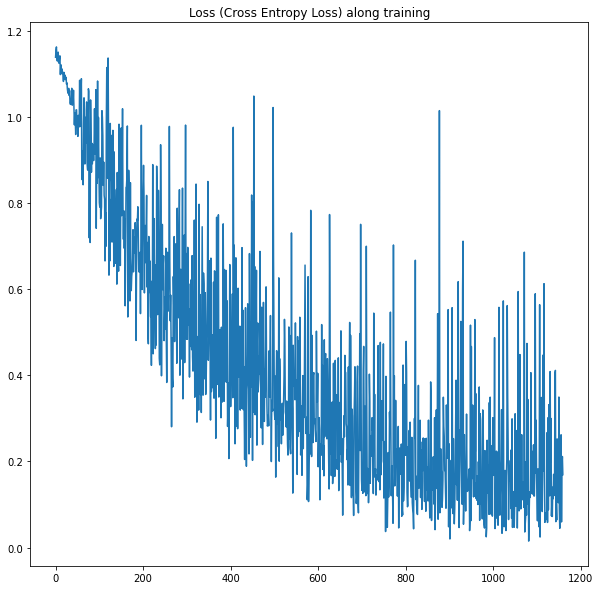

In [13]:
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.title("Loss (Cross Entropy Loss) along training")

Unsurprisingly the loss is dropping along training, with a quite high variance, that could be explained by the limited batch size thus the loss can be highly depending of having the model well fitted to the current batch or not.

# Transfer learning : ResNet 34

Our second approach is to use transfer learning with a much deeper model : ResNet-34 (Kaiming He et al., https://arxiv.org/abs/1512.03385). This model features blocks containing subblocks of $3\times 3$ convolution with various number of channels (64, 128, 256 and 512), totaling 34 convolutions layers. In addition the ResNet architecture uses batch-normalization inbetween convolutions to regularize the output. Finaly ResNet standardly uses adaptative average pooling to obtain a 512 features output then only one fully connected layer to get the desired number of logits.

In [14]:
resnet34=torchvision.models.resnet34(pretrained=True)
resnet34.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
print("Number of trainable parameters %s"%sum(p.numel() for p in resnet34.parameters() if p.requires_grad))

Number of trainable parameters 21797672


Although the model uses a single fully connected layer (that are expensive in terms of number of parameters) and mostly convolutions, it still has more than 21M parameters, that would require a long training to reach an ideal level.

In [16]:
resnet34(next(iter(trainloader))[0].to(device)).shape

torch.Size([16, 1000])

The output is of size 1000 (the model was pretrained using ImageNet) thus we ablate the last layer (by setting it to Identity) and will include the almost full ResNet-34 network as a block of a custom network. We uses 2 fully connected layers with a 0.2 dropout (randomly ignoring 20% of the parameters) to avoid overfitting and take advantage of the limited use of fully connected layers in ResNet.

In [17]:
resnet34.fc=nn.Identity()

In [18]:
resnet34(next(iter(trainloader))[0].to(device)).shape

torch.Size([16, 512])

# Method 1 : Freezing parameters and extracting features

Our first method with the pretrained ResNet-34 consists in extracting the final 512 features (as explained above) and training two new fully connected layers. All original parameters are frozen to their value and their gradients are not computing while training.

In [19]:
for param in resnet34.parameters():
    param.requires_grad=False

In [20]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet34 = resnet34
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, NUM_CLASSES)
        self.dropout=nn.Dropout(p=0.2)

    
    def forward(self, x):
        x = self.resnet34(x) #512
        x = F.relu(self.dropout(self.fc3(x))) #128
        x = self.dropout(self.fc4(x)) #3
        
        return x


resnet = ResNet().to(device)

We show an example output, here the last two layers (fully connected) are not trained and are thus randomly initialized.

In [21]:
resnet(next(iter(trainloader))[0].to(device))

tensor([[-0.2159,  0.0000, -0.3228],
        [-0.7699,  0.0000, -0.9620],
        [ 0.0000, -0.3931,  0.3269],
        [-0.1405, -0.0487, -0.4001],
        [ 0.1387, -0.1681, -0.0790],
        [ 0.0000, -0.1026, -1.1552],
        [-0.7035, -0.2737, -0.5629],
        [ 0.5602,  0.4250, -0.6176],
        [-0.3215,  0.2369, -0.0551],
        [-0.8686,  0.0498, -0.3340],
        [ 0.0000,  0.6034,  0.0000],
        [-0.7172, -0.4373,  0.0000],
        [-0.3176,  0.5478, -0.6817],
        [-0.5072,  0.0000, -0.9459],
        [ 0.0000,  0.1266, -0.6279],
        [ 0.0000, -0.1144, -0.2351]], device='cuda:0',
       grad_fn=<FusedDropoutBackward>)

In [22]:
print("Number of trainable parameters %s"%sum(p.numel() for p in resnet.parameters() if p.requires_grad))

Number of trainable parameters 66051


We only train a small number of parameters corresponding to the last two layers (but we still save the whole model with its 21M weights) every 2 epochs.

We keep the same criterion and optimizer but we use a scheduler. Thus the learning rate is set at a higher level at the beggining (0.1) to obtain a rough adjustment of the weights of the fully connected layers to the task, then (after half of the epochs) to make a more precise adjustment (with a learning rate of $0.01 \times \gamma = 0.001$. We did not choose to add more steps (and get a lower learning rate) to avoid overfitting.

In [23]:
criterion = nn.CrossEntropyLoss(weight=trainloader_weights)
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
scheduler= optim.lr_scheduler.StepLR(optimizer, step_size=int(num_epochs/2), gamma=0.1, last_epoch=-1, verbose=False)

try:
    os.makedirs("models/resnet")
except:
    pass

In [24]:
losses=Trainer(resnet, optimizer, criterion,model_name="resnet",scheduler=scheduler)

Start trainining resnet
[Epoch 1/40, batch 1/29] loss: 1.035 / Accuracy 0.4375 / Iteration in 0.034 s
[Epoch 1/40, batch 11/29] loss: 0.798 / Accuracy 0.6875 / Iteration in 0.027 s
[Epoch 1/40, batch 21/29] loss: 0.324 / Accuracy 0.875 / Iteration in 0.033 s
[Epoch 2/40, batch 1/29] loss: 0.302 / Accuracy 0.8125 / Iteration in 0.026 s
[Epoch 2/40, batch 11/29] loss: 0.372 / Accuracy 0.875 / Iteration in 0.037 s
[Epoch 2/40, batch 21/29] loss: 0.317 / Accuracy 0.9375 / Iteration in 0.037 s
Validation score (accuracy) : 0.8333333333333334
Best validation score so far
[Epoch 3/40, batch 1/29] loss: 0.409 / Accuracy 0.875 / Iteration in 0.039 s
[Epoch 3/40, batch 11/29] loss: 0.502 / Accuracy 0.875 / Iteration in 0.029 s
[Epoch 3/40, batch 21/29] loss: 0.259 / Accuracy 0.9375 / Iteration in 0.027 s
[Epoch 4/40, batch 1/29] loss: 0.333 / Accuracy 0.9375 / Iteration in 0.049 s
[Epoch 4/40, batch 11/29] loss: 0.605 / Accuracy 0.8125 / Iteration in 0.066 s
[Epoch 4/40, batch 21/29] loss: 0.486

Text(0.5, 1.0, 'Loss (Cross Entropy Loss) along training')

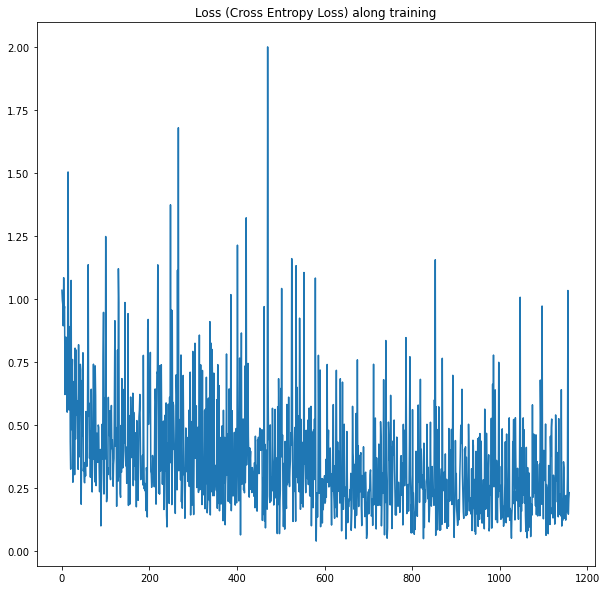

In [25]:
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.title("Loss (Cross Entropy Loss) along training")

# Method 2 : Fine Tuning of ResNet-34

We then uses ResNet-34 pretrained network with a different approach than feature extraction. We unfreeze the parameters and allow all parameters (original ResNet-34 parameters and the parameters of the last layers) to be updated. The difference between them is that the parameters of ResNet-34 are initialized to their pretrained value, while ours are randomly initialized. 

A third approach would be to reset all parameters and randomly initialized them then train the whole model, this would be great to have a specific network for our task but it would require a very high number of epochs and thus a long training.

In [26]:
for param in resnet.parameters():
    param.requires_grad=True

In [27]:
print("Number of trainable parameters %s"%sum(p.numel() for p in resnet.parameters() if p.requires_grad))

Number of trainable parameters 21350723


We now obtain a much more consequent network to train, although most of the parameters are already initialized at a "decent" value and will soon be well adjusted without requiring a lot of epochs.

In [28]:
criterion = nn.CrossEntropyLoss(weight=trainloader_weights)
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
scheduler= optim.lr_scheduler.StepLR(optimizer, step_size=int(num_epochs/2), gamma=0.1, last_epoch=-1, verbose=False)

try:
    os.makedirs("models/resnet_fine")
except:
    pass

In [29]:
losses=Trainer(resnet, optimizer, criterion,model_name="resnet_fine",scheduler=scheduler)

Start trainining resnet_fine
[Epoch 1/40, batch 1/29] loss: 0.095 / Accuracy 0.9375 / Iteration in 0.098 s
[Epoch 1/40, batch 11/29] loss: 0.689 / Accuracy 0.6875 / Iteration in 0.059 s
[Epoch 1/40, batch 21/29] loss: 0.201 / Accuracy 0.875 / Iteration in 0.059 s
[Epoch 2/40, batch 1/29] loss: 0.219 / Accuracy 0.875 / Iteration in 0.112 s
[Epoch 2/40, batch 11/29] loss: 0.127 / Accuracy 1.0 / Iteration in 0.067 s
[Epoch 2/40, batch 21/29] loss: 0.192 / Accuracy 0.9375 / Iteration in 0.063 s
Validation score (accuracy) : 0.7708333333333334
Best validation score so far
[Epoch 3/40, batch 1/29] loss: 0.148 / Accuracy 0.9375 / Iteration in 0.066 s
[Epoch 3/40, batch 11/29] loss: 0.481 / Accuracy 0.6875 / Iteration in 0.075 s
[Epoch 3/40, batch 21/29] loss: 0.235 / Accuracy 0.9375 / Iteration in 0.088 s
[Epoch 4/40, batch 1/29] loss: 0.417 / Accuracy 0.8125 / Iteration in 0.080 s
[Epoch 4/40, batch 11/29] loss: 0.292 / Accuracy 0.875 / Iteration in 0.074 s
[Epoch 4/40, batch 21/29] loss: 1.

Text(0.5, 1.0, 'Loss (Cross Entropy Loss) along training')

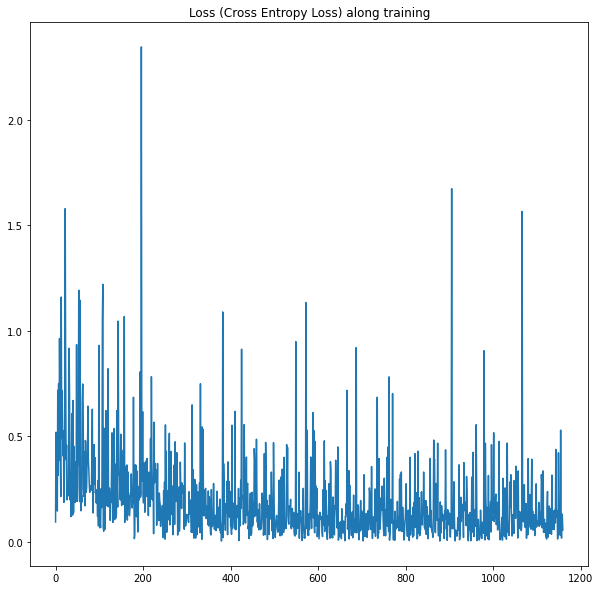

In [30]:
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.title("Loss (Cross Entropy Loss) along training")

# Evaluate results

We now want to evaluate the models on the test set. We will be comparing models at every 2 epochs regarding their overall accuracy.

The test data loader does not include transformations (we want to classify "original" images) but still needs to have resizing to be able to use the networks above, and normalization to be consistent with their training.

In [31]:
root_path="../input/panneauxv2/00_test"
#Create the dataset
test_dataset = dset.ImageFolder(root=root_path,
                               transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.RandomCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                           ]))

#withdraw the random flip and random perspective to keep the originals resized and cropped

# Create the dataloader
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,drop_last=True)

We here present an example of predictions using our 3 approaches.

In [32]:
net=Net()

num_epochs_test=num_epochs
save_path = './models/net/net_'+str(num_epochs_test)+'.pth'
net.load_state_dict(torch.load(save_path))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [33]:
resnet=ResNet()
save_path = './models/resnet/net_'+str(num_epochs_test)+'.pth'
resnet.load_state_dict(torch.load(save_path))
resnet.to(device)

ResNet(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [34]:
resnet_fine=ResNet()
save_path = './models/resnet_fine/net_'+str(num_epochs_test)+'.pth'
resnet_fine.load_state_dict(torch.load(save_path))
resnet_fine.to(device)

ResNet(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [35]:
testbatch=next(iter(testloader))

with torch.no_grad():
    predictions_net = net(testbatch[0].to(device))
    predictions_resnet = resnet(testbatch[0].to(device))
    predictions_resnet_fine = resnet_fine(testbatch[0].to(device))

values_net,argmax_net=torch.max(predictions_net,1)
values_resnet,argmax_resnet=torch.max(predictions_resnet,1)
values_resnet_fine,argmax_resnet_fine=torch.max(predictions_resnet_fine,1)

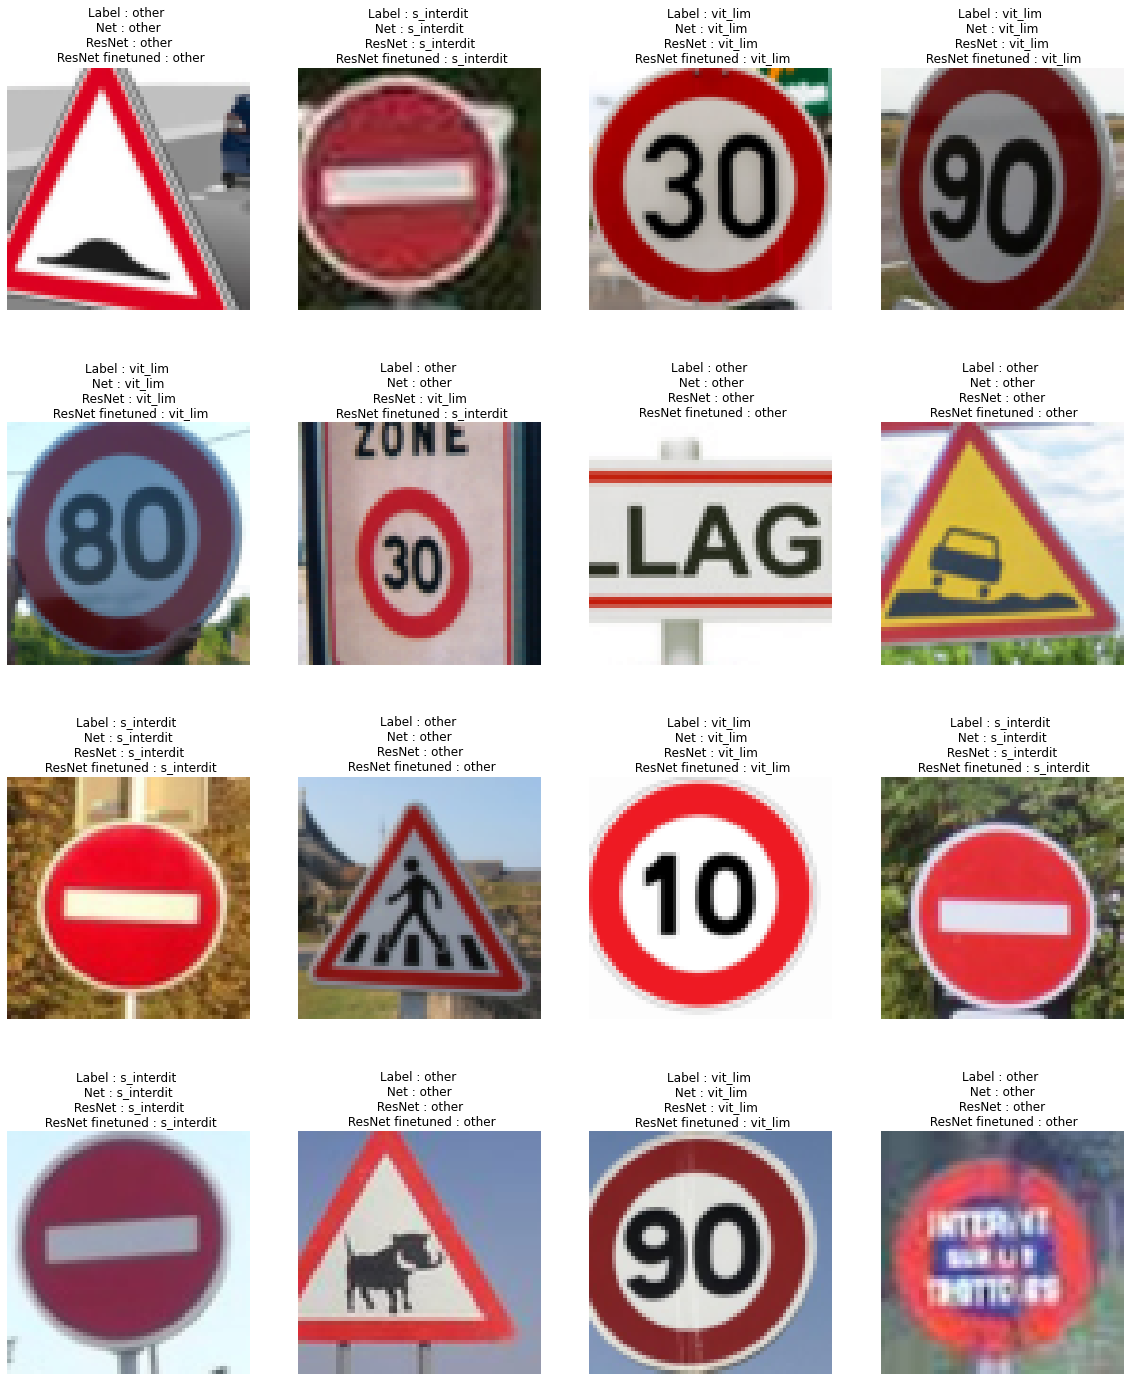

In [36]:
images=testbatch[0]
labels=testbatch[1]
images = images * STD[:, None, None] + MEAN[:, None, None]

plt.figure(figsize=(20,25))
i=0
for image,label in zip(images,labels):
    plt.subplot(4,4,i+1)
    plt.axis("off")
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.title("Label : %s \n Net : %s \n ResNet : %s \n ResNet finetuned : %s"%(label_names[label],label_names[argmax_net[i]],label_names[argmax_resnet[i]],label_names[argmax_resnet_fine[i]]))
    i+=1

Empirically it seems that ResNet model without fine tuning yields more errors, it could be causes by the unadaptated feature creation, that might be corrected with overtrained fully connected layers for the training set but does not work for the test set.

It is interesting to note that the detection can be easily alterated (we guessed the features are deeply modified even though human vision still perceive the original traffic sign on the below image).

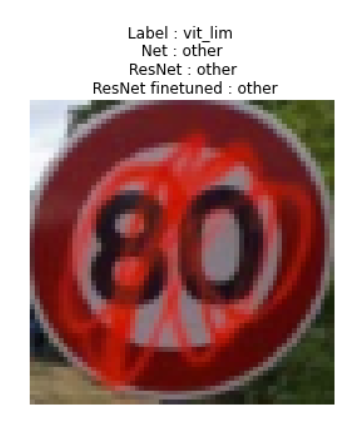

In [37]:
def compute_accuracy(model,loader=testloader,num_epoch_save=10,model_name="net"):
    model=model.to(device)
    save_path = './models/'+str(model_name)+'/net_'+str(num_epoch_save)+'.pth'
    #print(save_path)
    model.load_state_dict(torch.load(save_path))
    accuracies=[]
    for images,labels in loader:
        images=images.to(device)
        with torch.no_grad():
            outputs = model(images)
            maxvalue,argmax=torch.max(outputs,1)  
            local_accuracy=(argmax==labels.to(device)).sum().item()/batch_size
            accuracies.append(local_accuracy)
    return(np.mean(accuracies))


In [38]:
net_train_accuracies=[]
net_test_accuracies=[]
resnet_train_accuracies=[]
resnet_test_accuracies=[]
resnetfine_train_accuracies=[]
resnetfine_test_accuracies=[]
index=[]
for num in tqdm(range(1,num_epochs+1)):
    if num%save_epochs==0:
        index.append(num)
        net_train_accuracies.append(compute_accuracy(net,loader=trainloader,num_epoch_save=num,model_name="net"))
        net_test_accuracies.append(compute_accuracy(net,loader=testloader,num_epoch_save=num,model_name="net"))
        resnet_train_accuracies.append(compute_accuracy(resnet,loader=trainloader,num_epoch_save=num,model_name="resnet"))
        resnet_test_accuracies.append(compute_accuracy(resnet,loader=testloader,num_epoch_save=num,model_name="resnet"))
        resnetfine_train_accuracies.append(compute_accuracy(resnet,loader=trainloader,num_epoch_save=num,model_name="resnet_fine"))
        resnetfine_test_accuracies.append(compute_accuracy(resnet,loader=testloader,num_epoch_save=num,model_name="resnet_fine"))

100%|██████████| 40/40 [02:45<00:00,  4.15s/it]


Text(0.5, 1.0, 'Mean accuracy per epoch')

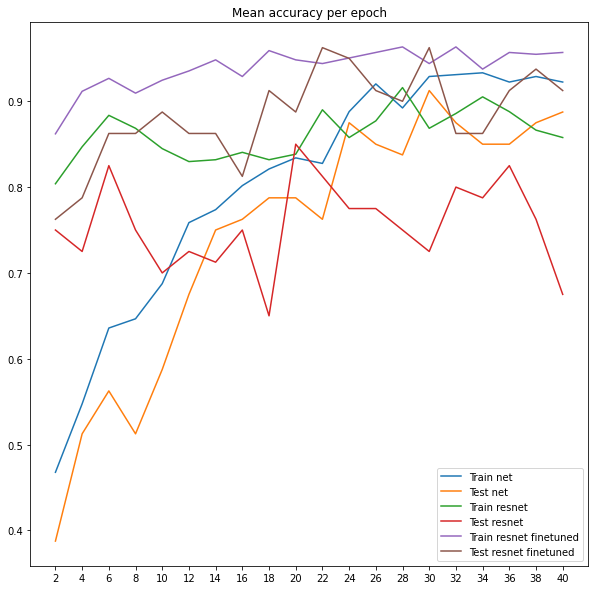

In [39]:
plt.figure(figsize=(10,10))
plt.plot(net_train_accuracies,label="Train net")
plt.plot(net_test_accuracies,label="Test net")
plt.plot(resnet_train_accuracies,label="Train resnet")
plt.plot(resnet_test_accuracies,label="Test resnet")
plt.plot(resnetfine_train_accuracies,label="Train resnet finetuned")
plt.plot(resnetfine_test_accuracies,label="Test resnet finetuned")
plt.xticks(range(0,int((num_epochs/save_epochs))),index)
plt.legend()
plt.title("Mean accuracy per epoch")

Along training for a same model it appears that most of the time the training accuracy is above the test accuracy, it denote a kind of overfitting. Even though training techniques can reduce it, it is to be expected when test and training sets are very different, and they might be because the samples are relatively limited.

It seems that ResNet Finetuned model suffers less from this issue, probably because of the numerous convolutions that may better extract global features whereas fully connected layers would tend to adapt themselves to very particular features.

# Best models accuracies

In [40]:
net=Net()
save_path = './models/net/bestnet.pth'
net.load_state_dict(torch.load(save_path))
net.to(device)

resnet=ResNet()
save_path = './models/resnet/bestnet.pth'
resnet.load_state_dict(torch.load(save_path))
resnet.to(device)

resnet_fine=ResNet()
save_path = './models/resnet_fine/bestnet.pth'
resnet_fine.load_state_dict(torch.load(save_path))
resnet_fine.to(device)

ResNet(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [41]:
def compute_best_accuracy(model,loader=testloader,model_name="net"):
    model=model.to(device)
    save_path = './models/'+str(model_name)+'/bestnet.pth'
    #print(save_path)
    model.load_state_dict(torch.load(save_path))
    accuracies=[]
    for images,labels in loader:
        images=images.to(device)
        with torch.no_grad():
            outputs = model(images)
            maxvalue,argmax=torch.max(outputs,1)
            local_accuracy=(argmax==labels.to(device)).sum().item()/batch_size
            accuracies.append(local_accuracy)
    return(np.mean(accuracies))

In [42]:
compute_best_accuracy(net,model_name="net")

0.85

In [43]:
compute_best_accuracy(resnet,model_name="resnet")

0.8125

In [44]:
compute_best_accuracy(resnet_fine,model_name="resnet_fine")

0.9125

It appears that the fine tuned ResNet model is the best one in terms of accuracy, but test accuracies are lower than the train accuracies (it could be expected because of overfitting) but also validation (it could be explained by a distribution issue because the validation set is very limited)

# Remarks

This comparision of CNN for classification purposes illustrates the interest of this kind of architecture for that kind of task. It is shown that it can achieve great performances (even though we remain quite far from state of the art accuracies on comparable tasks), even with a very limited network (6 layers) and a few parameters.

One of the main limitation of our work is the number of images. Collecting datas is a time-expensive task but having too limited datasets leads to a major problem, even though data augmentation may improve training : the distribution of images in each dataset is too different thus the validation set does not capture the diversity of images in the test set when selecting the best model (thus test performances might be lower than validation one).